### This notebook will be used to explore statcast data and train a ml model to predict betting odds for different pitch outcomes

In [ ]:
import pybaseball
from pybaseball import statcast
from pybaseball import  statcast_pitcher



from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.tree import plot_tree
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import beta, norm, binom
import scipy.optimize
from scipy.special import betaln

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import numpy as np

import itertools

import xgboost as xgb

 # Pull Data From Statcast
 Below we pull data from statcast over a 2 year time period ((start_dt='2023-06-24', end_dt='2025-06-24')). This request may take some time and cache is enabled due to the size of this request.

In [2]:
pybaseball.cache.enable()
df = statcast(start_dt='2023-06-24', end_dt='2025-06-24')

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 493/493 [02:21<00:00,  3.49it/s]
/opt/homebrew/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


# Explore Dataset
Below we are simply looking at the features in the data set and some of the metrics related to those features. Some values such as min,max,mean, etc. are irrevelant for categorical features, but can provide some insight for the numerical features in the data set.

In [ ]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2508,FF,2025-06-24,94.3,-1.18,5.64,"Iglesias, Raisel",596019,628452,field_out,hit_into_play,...,1,1.31,0.7,-0.7,38.7,0.889457,-4.937905,43.384277,34.742034,26.972696
2524,FF,2025-06-24,94.3,-1.32,5.56,"Iglesias, Raisel",596019,628452,None,swinging_strike,...,1,1.28,0.76,-0.76,40.6,0.699344,10.160129,43.474862,34.859079,20.992266
2618,CH,2025-06-24,86.5,-1.51,5.44,"Iglesias, Raisel",596019,628452,None,swinging_strike,...,1,2.63,1.34,-1.34,33.9,15.702425,-1.636676,38.587292,49.084237,30.493677
2719,FF,2025-06-24,94.6,-1.46,5.44,"Iglesias, Raisel",596019,628452,None,blocked_ball,...,1,1.14,0.6,-0.6,34.1,<NA>,<NA>,<NA>,<NA>,<NA>
2924,CH,2025-06-24,88.0,-1.65,5.45,"Iglesias, Raisel",677595,628452,double,hit_into_play,...,1,2.18,1.21,-1.21,34.5,8.886125,-17.345124,20.223029,42.808848,46.358165


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1547902 entries, 2508 to 4359
Columns: 118 entries, pitch_type to intercept_ball_minus_batter_pos_y_inches
dtypes: Float64(42), Int64(59), datetime64[ns](1), object(16)
memory usage: 1.5+ GB


In [5]:
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    display(df.describe(include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
pitch_type,1513531,18,FF,481971,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_date,1547902,NaN,NaN,NaN,2024-06-24 11:12:21.865569792,2023-06-24 00:00:00,2023-10-07 00:00:00,2024-06-24 00:00:00,2025-03-16 00:00:00,2025-06-24 00:00:00,NaN
release_speed,1512461.0,<NA>,<NA>,<NA>,89.171956,31.9,84.9,90.0,94.0,105.5,6.041617
release_pos_x,1512454.0,<NA>,<NA>,<NA>,-0.840768,-5.14,-2.16,-1.53,0.79,4.71,1.867924
release_pos_z,1512454.0,<NA>,<NA>,<NA>,5.761049,0.78,5.49,5.81,6.08,8.06,0.524147
player_name,1547902,1647,"Wheeler, Zack",7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
batter,1547902.0,<NA>,<NA>,<NA>,643061.923644,408234.0,621493.0,664023.0,672761.0,828599.0,52924.850572
pitcher,1547902.0,<NA>,<NA>,<NA>,637720.770159,425794.0,607481.0,657376.0,671922.0,829272.0,55135.889025
events,400245,22,field_out,160028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,1547902,17,ball,514866,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analyze Missing Data

In [ ]:
missing_df = \
pd.DataFrame(data = { 'missing_cnt': df.isna().sum(),
                      'missing_pct':df.isna().mean() * 100
                    }
            )

(
    missing_df[missing_df.missing_cnt > 0]
        .style
        .set_table_attributes(
            'style="display:block; max-height:400px; overflow-y:auto"'
        )
)


### Remove Unnecessary Features
Below we will remove a large number of features in the data set that are not used for model training or future feature engineering. Some of the features that may have been useful were removed if they had a siginficant % of missing data; too much to try and impute. 

In [8]:
df_copy = df.copy()
drop_features = ['game_date', 'player_name', 'game_date', 'type', 'sv_id', 'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in',
                 'des', 'type', 'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7' ,'fielder_8' ,'fielder_9',
                'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'iso_value', 'home_score', 'away_score', 'pitcher_days_until_next_game', 'batter_days_until_next_game'
]

for col in df_copy.columns:
    if 'deprecated' in col or 'legacy' in col:
        drop_features.append(col)

df_copy.drop(columns=drop_features)

# drop features with 'deprecated' or 'legacy' in their name

,pitch_type,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,spin_dir,zone,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2508,FF,94.3,-1.18,5.64,596019,628452,field_out,hit_into_play,<NA>,8,...,1,4,1,1,38.7,0.889457,-4.937905,43.384277,34.742034,26.972696
2524,FF,94.3,-1.32,5.56,596019,628452,None,swinging_strike,<NA>,8,...,1,4,1,1,40.6,0.699344,10.160129,43.474862,34.859079,20.992266
2618,CH,86.5,-1.51,5.44,596019,628452,None,swinging_strike,<NA>,13,...,1,4,1,1,33.9,15.702425,-1.636676,38.587292,49.084237,30.493677
2719,FF,94.6,-1.46,5.44,596019,628452,None,blocked_ball,<NA>,14,...,1,4,1,1,34.1,<NA>,<NA>,<NA>,<NA>,<NA>
2924,CH,88.0,-1.65,5.45,677595,628452,double,hit_into_play,<NA>,4,...,1,3,1,2,34.5,8.886125,-17.345124,20.223029,42.808848,46.358165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3797,FC,86.3,-2.32,6.43,661388,676440,strikeout,swinging_strike,<NA>,14,...,1,0,6,1,52.2,<NA>,<NA>,<NA>,<NA>,<NA>
3967,FC,83.3,-2.4,6.4,661388,676440,None,called_strike,<NA>,4,...,1,0,6,1,52.4,<NA>,<NA>,<NA>,<NA>,<NA>
4096,FF,93.7,-1.88,6.59,661388,676440,None,foul_tip,<NA>,3,...,1,0,6,1,66.1,<NA>,<NA>,<NA>,<NA>,<NA>
4281,FF,92.3,-2.02,6.55,592885,676440,single,hit_into_play,<NA>,11,...,1,0,6,1,60.4,<NA>,<NA>,<NA>,<NA>,<NA>


# Mapping Outcomes to Target Features

## Coarse Outcomes
The eventual goal is to create a model that can predict all possible outcomes of a pitch at a more granular level. However, it is advisable to start with a model that predicts fewer outcomes that are combinations of the more granular outcomes. Then once we get a stable model, we can start to split the outcomes out. The outcomes we will start with are: ball, strike, non-strike foul, and hit.

In [9]:
def map_outcome_coarse(row):
    strikes = ['called_strike', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip', 'missed_bunt', 'bunt_foul_tip', 'automatic_strike']
    balls = ['pitchout', 'ball', 'blocked_ball', 'intent_ball', 'automatic_ball']

    if row["description"] in balls:
        return "ball"
    
    if  row["description"] in strikes:
        return "strike"
    
    if row["description"] == "foul" and row['strikes'] == 2:
        return "non-strike foul"

    if row["description"] == "foul_bunt" and row['strikes'] == 2:
        return "non-strike foul"
    
    if row["description"] == "foul_pitchout" and row['strikes'] == 2:
        return "non-strike foul"
    
    if row["description"] == "foul" and row['strikes'] < 2:
        return "strike"
    
    if row["description"] == "foul_pitchout" and row['strikes'] < 2:
        return "strike"
    
    if row["description"] == "foul_bunt" and row['strikes'] < 2:
        return "strike"
    
    hits = ['hit_into_play', 'hit_by_pitch']
    if row['description'] in hits:
        return "hit"

df_copy['outcome_coarse'] = df_copy.apply(map_outcome_coarse, axis=1)

df_copy = df_copy.reset_index(drop=True)

In [10]:
df_copy['is_strike'] = df_copy['outcome_coarse'].isin(['strike'])
df_copy['is_hit'] = df_copy['outcome_coarse'].isin(['hit'])
df_copy['is_ball'] = df_copy['outcome_coarse'].isin(['ball'])
df_copy['is_foul'] = df_copy['outcome_coarse'].isin(['non-strike foul'])

# Visualize Distribution of Outcomes

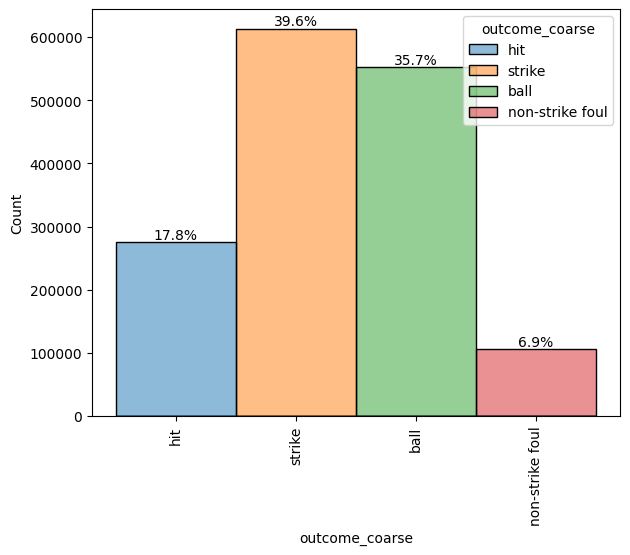

In [11]:
fig, ax = plt.subplots() #2,1, figsize=(8,10)
sns.histplot(data = df_copy, ax=ax, x='outcome_coarse', hue='outcome_coarse')
# sns.histplot(data = df, ax=ax[1], x='outcome', hue='outcome', stat='percent')

#Calculate percentages and add labels
total = len(df_copy['outcome_coarse'])
for p in ax.patches:
    height = p.get_height()
    if height>0:
        percentage = f'{(height / total * 100):.1f}%' # calculate percentage
        ax.text(p.get_x() + p.get_width() / 2.,
                height,
                percentage,
                ha='center', va='bottom')

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

Above, we can see the distribution of outcomes. We can see that strikes and balls are most common, followed by hit, and then on-strike foul being the least common.

# Pitcher Strike Rate
As one may imagine, an important feature for predicting outcomes of a given pitch would be a pitchers strike rate. In fact, there are many different rates that can be useful for predicting pitch outcome -- for example, ball rate of pitcher, hit rate of pitcher, strike rate of batter, hit rate of batter, etc. 

We will start by going through pitcher strike rate to see how this is done in greater detail before engineering other rate features may use in model training.




Below I create a dataframe that captures strike rate data for each pitcher. The new dataframe has features for strike_rate, totatl_pitches, and strike_count. This is done using group by on pitcher id from the original dataframe and aggregation functions.

In [153]:
pitcher_df = (
    # assign creates new, temporary copy of df with is_strike column
    df_copy.assign(is_strike=df_copy["outcome_coarse"].isin(['strike']))
      .groupby("pitcher", as_index=False) # want to get strike rate for each ind. pitcher, so group by pitcher (player id)
      .agg( # agg will perform specified aggregate measurements for each pitcher
          strike_rate=("is_strike", "mean"), # get strike rate (mean of strikes thrown)
          total_pitches=("is_strike", "size"), # get number of pitches thrown
          strike_count=("is_strike", "sum") # get strike count
      )
)

### Histplot of Pitcher Strike Rate

<function matplotlib.pyplot.show(close=None, block=None)>

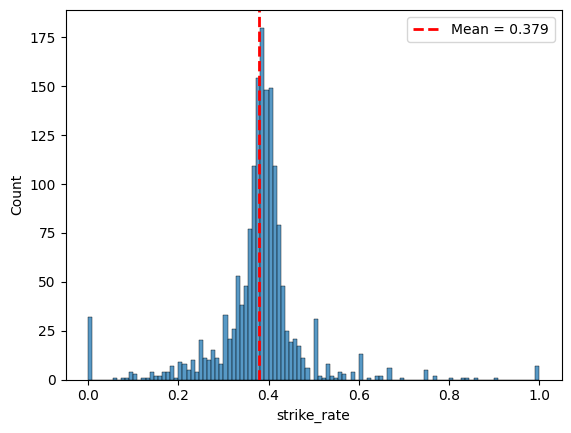

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=pitcher_df, ax=ax, x='strike_rate')
mean_strike_rate = pitcher_df['strike_rate'].mean()
std_strike_rate = pitcher_df["strike_rate"].std()
ax.axvline(
    mean_strike_rate,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean = {mean_strike_rate:.3f}"
)

ax.legend()
plt.show

# Apply Beta-Binomial Empirical Bayes Shrinkage
MLB data is very noisy. There are many players with a small amount of data associated with them. When we are doing feature engineering, for example creating a pitcher strike rate feature, this can be a problem. We can't trust a pitcher who is throwing a strike rate of 90% but has only thrown 10 pitches. One of the best solutions to this problem is to use Empirical Bayes shrinkage. For strike-rates specifically, we will be using Beta-Binomial Empirical Bayes Shrinkage to adjust pitcher strike rates.

### Step 1) Binomial Likelihood

To start we need to review a few concepts. Firstly, we can think of each pitch a pitcher has thrown as an individual Bernoulli trial with some pitcher-specific probability of throwing a strike:
p_i = Pr(strike on pitch for pitcher i). When we think about it in this context, we can find the probability of pitcher i throwing y strikes in n pitches modeled by a binomial distribution PMF. Pr(y | n, p_i) = Binomial(y,n,P_i) = (n choose y​)*p_i^y*(1−p_i)^(n−y). However, we don't know the pitchers p_i. How do we use this equation to find the probability of a pitcher throwing a strike on a given pitch (p_i)? Well intuitively you might think, divide the number of strikes the pitcher threw (y) by the total number of pitches the pitcher threw (n). And you wouldn't necessarily be wrong. But we can do this in a stastical fashion by reframing our question in terms of the binomial likelihood of p_i. In this context, we are calculating the likelihood of different values of p_i given that pitcher i threw y strikes and n total pitches. This can be written as L(p_i | y,n) = (n choose y​)*p_i^y*(1−p_i)^(n−y).

Below we create a python function that returns the likelihoods of each potential probability of pitcher i throwing a strike. We do so using the function described above for a pitcher who has thrown 60 strikes in 100 pitches. We then normalize these likelihoods to relative likelihoods and graph the relative likelihoods for each value of p_i.

In [14]:
# create likelihood function
def binomial_likelihood(p_grid, y, n):
    return p_grid**y * (1-p_grid)**(n-y)

y = 60
n = 100
p_grid = np.linspace(0,1,1000)

# get likelihoods
likelihoods = binomial_likelihood(p_grid, y, n)
# normalize likelihoods to give relative likelihoods
relative_likelihoods = likelihoods/likelihoods.max()

Text(0.5, 1.0, 'Relative Likelihood of p_i')

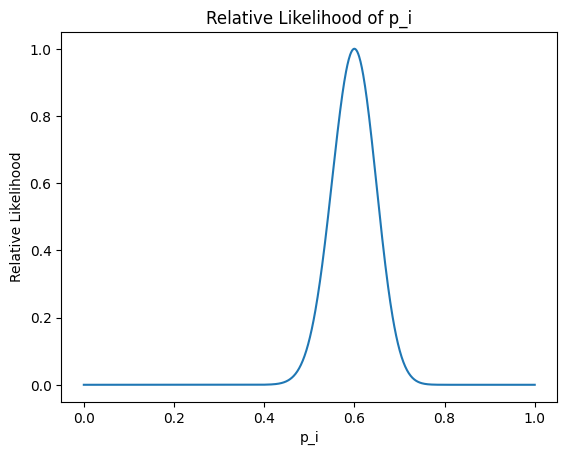

In [15]:
fig, ax = plt.subplots()
sns.lineplot(ax=ax,x=p_grid,y=relative_likelihoods)
ax.set_xlabel('p_i')
ax.set_ylabel('Relative Likelihood')
ax.set_title('Relative Likelihood of p_i')

As you can see, what we get is a continuous bell shape curve over all values of p_i that is centered on p_i = 0.6. p_i = 0.6 is our maximum liklihood estimation of p_i. Given our data (60 strikes out of 100 pitches), this makes sense as 60/100 = 0.6. We can see there is some variance and p_i between 0.5 - 0.7 are in the range of possible p_i's. The more pitches a pitcher throws, the tighter this distribution becomes, and the less variance we have.

### Step 2) Generate Our Prior: Beta distribution
Now that we have an understanding of how to model the likelihood of different p_i's for every pitcher using binomial-likelihood, we have an idea of what our pitcher's strike rate is and how it might vary. However, we have league wide knowledge: We have data for every pitch in the league over 2 seasons in our data that we pulled. We can use this knowledge to adjust each pitchers strike rate (p_i) estimate to be closer to the league-wide mean strike rate. To do this, we need to formally/statistically model our prior knowledge. We do so using a Beta distribution given that a Beta distribution models probabilities (values between 0 and 1) and their probability densities. 

The Beta distribution has two parameters alpha, and beta_param. Lets say P is the probability of any pitcher in the league throwing a strike on a given pitch. Then P ~ Beta(alpha,beta_param). We want to model P in such a way that removes out pitcher talent (variance in pitcher talent). To do this we will use Marginal Likelihood Empirical Bayes to estmiate the league wide Beta prior by choosing alpha and beta_param that make the observed pitcher strike counts most probable after integrating out pitcher talent. We will estimate our league wide strike rate to be the average of all the leagues strikes/number of pitches thrown.

Below we use the joint beta-binomial marginal likelihood function to calculate the optimal alpha and beta parameters for our pitcher strike rate prior.

In [ ]:
pitchers_copy = pitcher_df.copy()

y = pitchers_copy['strike_count']
n = pitchers_copy['total_pitches']

mu = (y/n).mean()


def neg_log_marginal_likelihood(kappa):

    alpha = mu * kappa
    beta = (1-mu)*kappa

    # calculate joint beta-binomial marginal likelihood
    loglik = np.sum(betaln(y+alpha,n-y+beta)-betaln(alpha,beta))
    
    return -loglik # we minimize later, make negative to do so

res = scipy.optimize.minimize(neg_log_marginal_likelihood, x0 = 10, bounds=[(0.01,None)])
kappa_hat = res.x[0]
alpha_hat = mu * kappa_hat
beta_hat = (1-mu)*kappa_hat

print("Estimated alpha:", alpha_hat)
print("Estimated beta:", beta_hat)

Estimated alpha: 140.0710963130126
Estimated beta: 229.3893411447054


### Step 3) Visualize Our Prior: Beta(alpha_hat,beta_hat)
Below we have a graph showing the prior distribution of pitchers strike rates across the league that we calculated above.

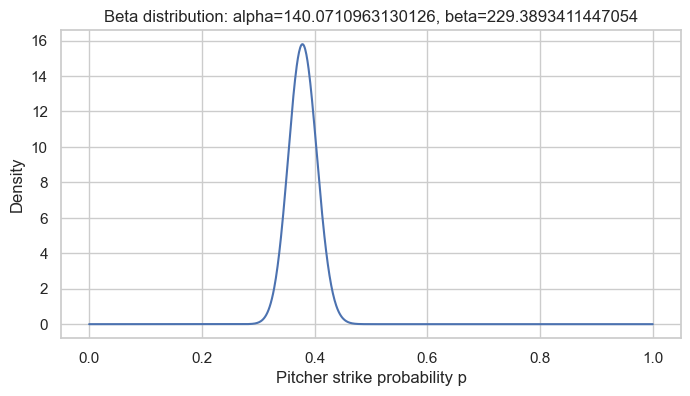

In [ ]:
# Dense grid of x values between 0 and 1
x = np.linspace(0, 1, 1000)

# Evaluate Beta pdf
y = beta.pdf(x, alpha_hat, beta_hat)

# Plot with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.lineplot(x=x, y=y)
plt.xlabel("Pitcher strike probability p")
plt.ylabel("Density")
plt.title(f"Beta distribution: alpha={alpha_hat}, beta={beta_hat}")
plt.show()


### Step 4) Perform Empirical Bayes Shrinkage 
Now that we have our data (pitchers strikes and pitches thrown) as well as our prior, we can calculate the adjusted strike rate for each pitcher (posterior). This will be our estimate of the pitchers strike rate for each pitcher. Below is an example of how this is applied for our pitcher who has thrown 60 strikes in 100 pitches.

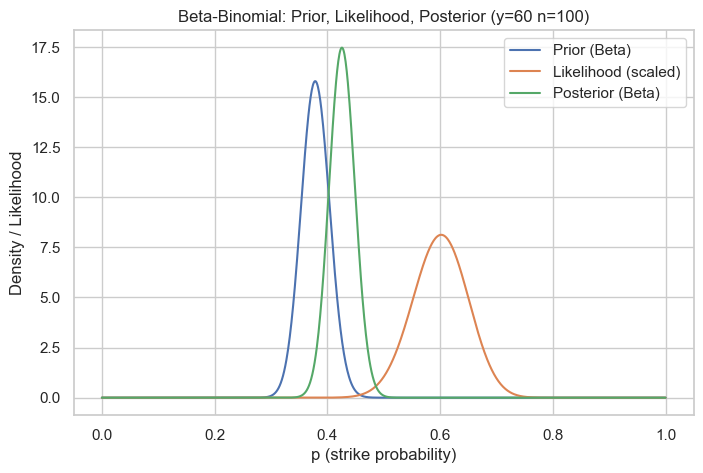

In [ ]:
# Data
y_obs = 60   # number of strikes observed
n_obs = 100  # total pitches

# Prior parameters
# alpha_hat = 5
# beta_hat = 5

# Grid of probabilities
x = np.linspace(0, 1, 1000)

# 1. Likelihood (Binomial PMF, evaluated as function of p)
likelihoods = beta.pdf(x, y_obs, n_obs-y_obs)

# 2. Prior (Beta PDF)
prior = beta.pdf(x, alpha_hat, beta_hat)

# 3. Posterior (Beta PDF)
posterior = beta.pdf(x, alpha_hat + y_obs, beta_hat + (n_obs - y_obs))

# Plot
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x=x, y=prior, ax=ax, label='Prior (Beta)')
sns.lineplot(x=x, y=likelihoods, ax=ax, label='Likelihood (scaled)')
sns.lineplot(x=x, y=posterior, ax=ax, label='Posterior (Beta)')
ax.set_xlabel("p (strike probability)")
ax.set_ylabel("Density / Likelihood")
ax.set_title(f"Beta-Binomial: Prior, Likelihood, Posterior (y={y_obs} n={n_obs})")
plt.legend()
plt.show()


In [18]:
# calculate p_i for every pitcher
def beta_binom_ebs(alpha_param, beta_param, y, n):
    # calculate mean of posterior
    posterior_mean = (alpha_param + y) / (alpha_param + beta_param + n)
    return posterior_mean

pitchers_copy['strike_rate_eb'] = beta_binom_ebs(
    alpha_hat,
    beta_hat,
    pitchers_copy['strike_count'],
    pitchers_copy['total_pitches']
)

### Updated Pitcher Strike Rates
Below is a visualization of the frequency histogram of pitcher strike rates after Empirical Bayes Shrinkage has been applied. We can see that the graph has a much smaller range of values and there are no extreme outliers any longer.

<function matplotlib.pyplot.show(close=None, block=None)>

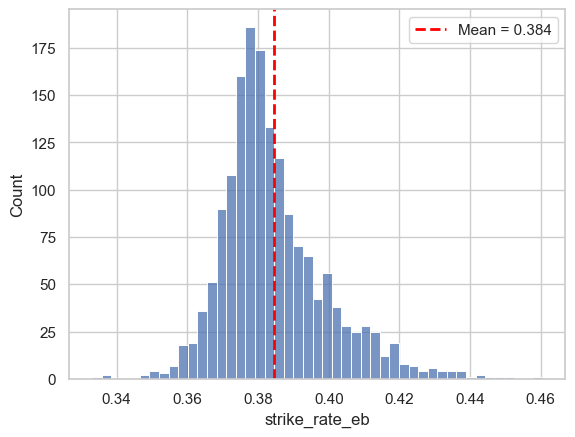

In [19]:
fig, ax = plt.subplots()
sns.histplot(data=pitchers_copy, ax=ax, x='strike_rate_eb')
mean_strike_rate = pitchers_copy['strike_rate_eb'].mean()
std_strike_rate = pitchers_copy["strike_rate_eb"].std()
ax.axvline(
    mean_strike_rate,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean = {mean_strike_rate:.3f}"
)

ax.legend()
plt.show

# Empirical Bayes Shrinkage Feature Engineering
Below we split the data into training and testing and validation dataframes. We then create our own sklearn transformer that can perform Empirical Bayes Shrinkage in an sklearn preprocessing pipeline.

In [154]:
# split dataframe into trianing and testing
df_copy2 = df_copy.copy()

train_df, test_df= train_test_split(
    df_copy2,
    test_size=0.2,
    random_state=42)

train_df, val_df = train_test_split(
    train_df, 
    test_size=0.2,
    random_state=42)

### Step 1: make marginal likelihood our fit method and make it stateless

In [155]:
class BetaBinomialPrior:
    # fit will take in y (success col) and n (total col)
    def fit(self, y, n):
        mu = y.sum()/n.sum()

        # create negative likelihood function
        def nll(kappa):

            alpha = mu * kappa
            beta = (1-mu)*kappa

            # calculate joint beta-binomial marginal likelihood
            loglik = np.sum(betaln(y+alpha,n-y+beta)-betaln(alpha,beta))
            
            return -loglik # we minimize later, make negative to do so

        res = scipy.optimize.minimize(nll, x0 = 10, bounds=[(0.01,None)])
        kappa_hat = res.x[0]
        self.alpha_ = mu * kappa_hat
        self.beta_ = (1-mu)*kappa_hat
        self.mu_ = mu

        return self

    def posterior_mean(self, y, n):
        return (y + self.alpha_) / (n + self.alpha_ + self.beta_)
                    

### Step 2: Player-level EB Transformer

In [ ]:
# create sklearn fit transform pipeline which leverages BetaBinomialPrior class
class PlayerEBRateTransformer(BaseEstimator, TransformerMixin):

    # init vars
    def __init__(self, player_col, success_col, output_col):
        self.player_col = player_col
        self.success_col = success_col
        self.output_col = output_col
    
    # fit prior to data, calculate posteriorsT
    def fit(self, X, y=None):
        # group by player id column, get success and totals for each player
        grouped = (
            X.groupby(self.player_col)
            .agg(
                y = (self.success_col, "sum"),
                n = (self.success_col, "size")
            )
        )
        
        # calculate prior using neg log likelihood method in BetaBinomialPrior().fit()
        # provide successes and failure values for each player to make this estimation
        self.prior_ = BetaBinomialPrior().fit(
            grouped['y'].values,
            grouped['n'].values
        )

        # calculate posterior mean (new metric estimate) for each player in pivot
        grouped[self.output_col] = self.prior_.posterior_mean(
            grouped['y'].values,
            grouped['n'].values
        )

        # create lookup table and default values for pitchers
        self.lookup_ = grouped[self.output_col].to_dict()
        self.default_ = self.prior_.mu_

        return self
    
    # create transform funciton to set column values to lookup values or default if not present
    def transform(self, X):
        X = X.copy()
        X[self.output_col] = (
            X[self.player_col]
            .map(self.lookup_)
            .fillna(self.default_)
        )
        return X


### Step 3: Use this Class in a Pipeline

In [157]:
from sklearn.pipeline import Pipeline

# create sklearn pipeline to transform the data using empirical bayes shrinkage
eb_pipeline = Pipeline([
    ("pitcher_strike_eb", PlayerEBRateTransformer(
        player_col="pitcher",
        success_col="is_strike",
        # total_col="pitch_id",
        output_col="pitcher_strike_rate_eb"
    )),
    ("pitcher_ball_eb", PlayerEBRateTransformer(
        player_col="pitcher",
        success_col="is_ball",
        # total_col="pitch_id",
        output_col="pitcher_ball_rate_eb"
    )),
    ("pitcher_hit_eb", PlayerEBRateTransformer(
        player_col="pitcher",
        success_col="is_hit",
        # total_col="pitch_id",
        output_col="pitcher_hit_rate_eb"
    )),
    ("batter_hit_eb", PlayerEBRateTransformer(
        player_col="batter",
        success_col="is_hit",
        # total_col="pitch_id",
        output_col="batter_hit_rate_eb"
    )),
    ("batter_strike_eb", PlayerEBRateTransformer(
        player_col="batter",
        success_col="is_strike",
        # total_col="pitch_id",
        output_col="batter_strike_rate_eb"
    )),
    ("batter_ball_eb", PlayerEBRateTransformer(
        player_col="batter",
        success_col="is_ball",
        # total_col="pitch_id",
        output_col="batter_ball_rate_eb"
    )),
])

### Step 4: Apply Empirical Bayes Shrinkage to Training and Test Sets
Below we will now use our empirical bayes shrinkage data transformer pipeline to fit the transformations to the training data and then transform the training and testing data to have Empirical Bayes shrunk rates for the various rates we have included (ie. pitcher_strike_rate_eb)

In [158]:

X_train = eb_pipeline.fit_transform(train_df)
X_test=eb_pipeline.transform(test_df)
X_val = eb_pipeline.transform(val_df) 


## Emprical Bayes Shrinkage vs. No Shrinkage
Below we create new dataframes that contain the different quantiles for the raw strike rates and eb strike rates and their associated outcome probabilities (proba strike, ball, foul, hit). 

In [159]:
# Make sure your EB strike rate column exists
# X_train['pitcher_strike_rate_eb'] 

X_val['pitcher_strike_rate_raw'] = X_val.groupby('pitcher')['is_strike'].transform('mean')
# Create quantile bins for raw and EB strike rates
X_val['raw_strike_rate_bin'] = pd.qcut(X_val['pitcher_strike_rate_raw'], q=10)
X_val['eb_strike_rate_bin']  = pd.qcut(X_val['pitcher_strike_rate_eb'], q=10)

# Function to calculate outcome distributions per bin
def get_dist(df, bin_col):
    dist = (
        df.groupby(bin_col)['outcome_coarse']
          .value_counts(normalize=True)
          .unstack()
    )
    dist = dist.reset_index().melt(
        id_vars=bin_col,
        var_name='outcome',
        value_name='probability'
    )
    # Convert bins to midpoints for plotting
    dist[bin_col + '_mid'] = dist[bin_col].apply(lambda x: x.mid)
    return dist

dist_raw = get_dist(X_val, 'raw_strike_rate_bin')
dist_eb  = get_dist(X_val, 'eb_strike_rate_bin')

dist_eb.head(60)

/var/folders/lb/23387f852w12tqnqvkyjrvrw0000gn/T/ipykernel_80257/3176649022.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(bin_col)['outcome_coarse']
/var/folders/lb/23387f852w12tqnqvkyjrvrw0000gn/T/ipykernel_80257/3176649022.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(bin_col)['outcome_coarse']


,eb_strike_rate_bin,outcome,probability,eb_strike_rate_bin_mid
0,"(0.349, 0.381]",ball,0.372320,0.3650
1,"(0.381, 0.385]",ball,0.366611,0.3830
2,"(0.385, 0.389]",ball,0.361021,0.3870
3,"(0.389, 0.393]",ball,0.354809,0.3910
4,"(0.393, 0.397]",ball,0.367837,0.3950
5,"(0.397, 0.4]",ball,0.363068,0.3985
6,"(0.4, 0.404]",ball,0.356008,0.4020
7,"(0.404, 0.408]",ball,0.352102,0.4060
8,"(0.408, 0.415]",ball,0.346723,0.4115
9,"(0.415, 0.439]",ball,0.335668,0.4270


### Graph 1: Pitch Outcome Probabilities vs. Raw Pitcher Strike Rates

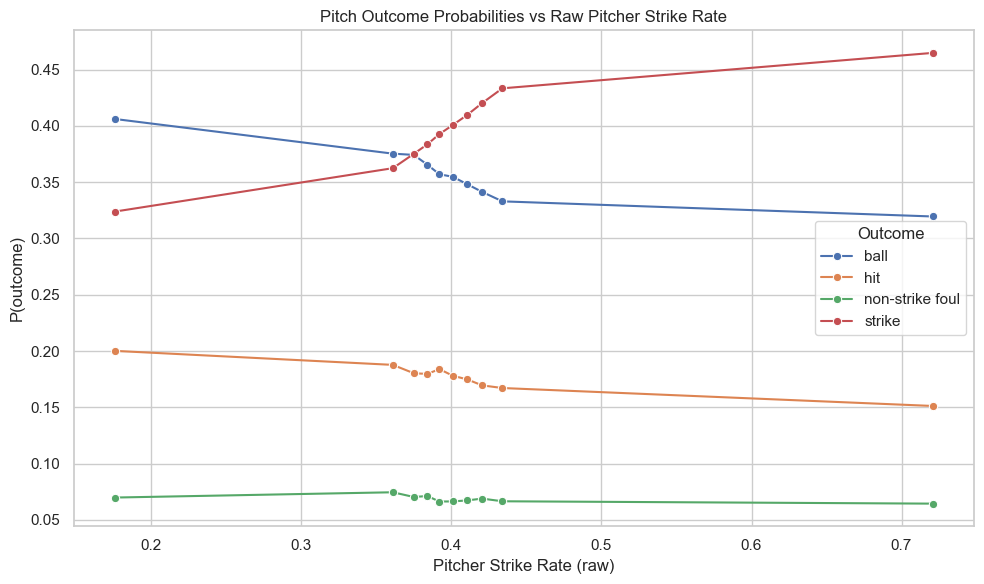

In [160]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=dist_raw,
    x="raw_strike_rate_bin_mid",
    y="probability",
    hue="outcome",
    marker="o"
)

plt.xlabel("Pitcher Strike Rate (raw)")
plt.ylabel("P(outcome)")
plt.title("Pitch Outcome Probabilities vs Raw Pitcher Strike Rate")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

### Graph 2: Outcome Probabilities vs. Empirical Bayes Shrunk Pitcher Strike Rate 

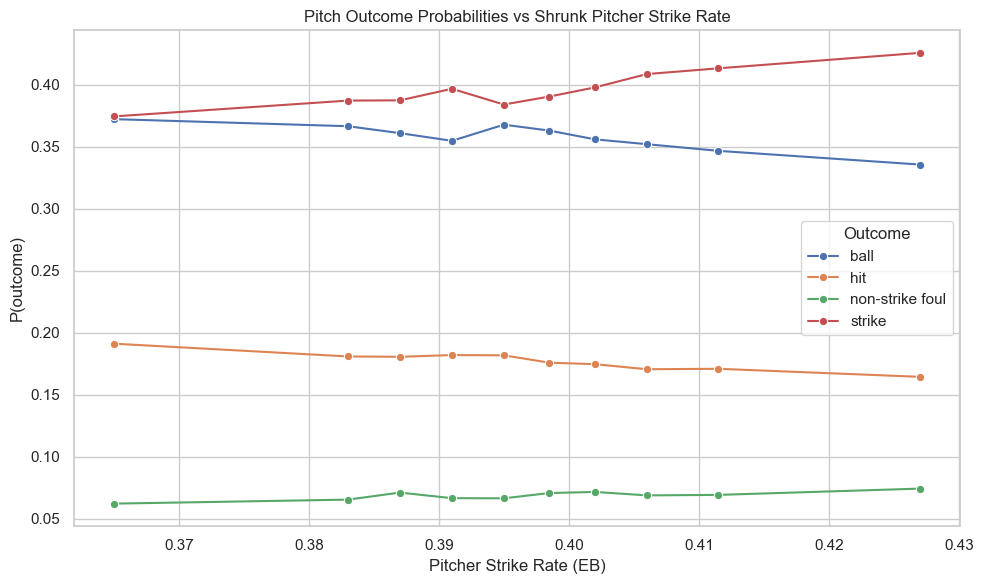

In [161]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=dist_eb,
    x="eb_strike_rate_bin_mid",
    y="probability",
    hue="outcome",
    marker="o"
)

plt.xlabel("Pitcher Strike Rate (EB)")
plt.ylabel("P(outcome)")
plt.title("Pitch Outcome Probabilities vs Shrunk Pitcher Strike Rate")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()


# print(dist_long)

### Gaph 3: Effect of Raw vs. EB-Shrunk Strike Rate on Pitch Outcome Probabilities

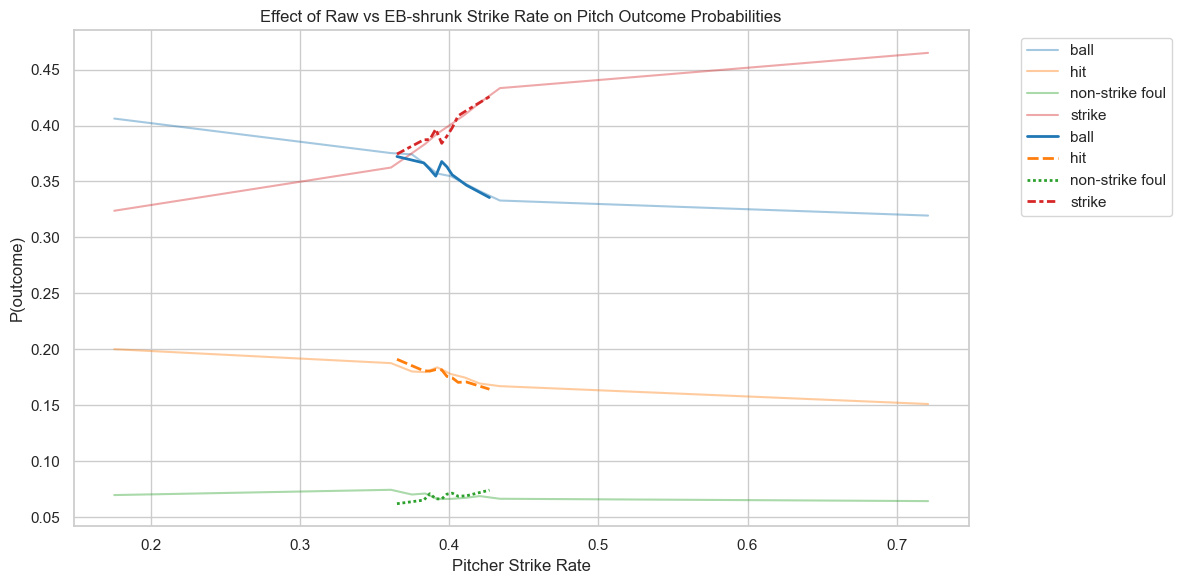

In [28]:
# Plot overlay lineplots
plt.figure(figsize=(12,6))

# Raw strike rate (semi-transparent)
sns.lineplot(
    data=dist_raw,
    x='raw_strike_rate_bin_mid',
    y='probability',
    hue='outcome',
    style='outcome',
    dashes=False,
    alpha=0.4,
    palette='tab10'
)

# EB strike rate (thicker lines)
sns.lineplot(
    data=dist_eb,
    x='eb_strike_rate_bin_mid',
    y='probability',
    hue='outcome',
    style='outcome',
    dashes=True,
    linewidth=2,
    palette='tab10'
)

plt.xlabel("Pitcher Strike Rate")
plt.ylabel("P(outcome)")
plt.title("Effect of Raw vs EB-shrunk Strike Rate on Pitch Outcome Probabilities")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Feature Engineering Part 2: KMeans Clustering
K-Means clustering is an unsupervised machine learning algorithm that partitions a dataset into k distinct, non-overlapping subgroups (Arthur & Vassilvitskii, 2007). In the context of this research, each pitcher (and batter) is represented as a point in a three-dimensional feature space defined by:


EB-Shrunk Strike Rate (x)

EB-Shrunk Ball Rate (y)

EB-Shrunk Hit Rate (z)


The algorithm works by iteratively minimizing the Within-Cluster Sum of Squares (WCSS), essentially finding the "gravitational centers" (centroids) of different playing styles. By using Empirical Bayes (EB) shrunk rates as the input, the clustering is performed on "true-skill" estimates rather than noisy, unadjusted season averages, ensuring that the resulting archetypes are stable and not biased by small sample sizes.


The algorithm identifies patterns in how players distribute their pitch outcomes. For example:

Pitcher Archetype A (The Zone-Pounder): A cluster center characterized by a high Strike Rate, low Ball Rate, and moderate Hit Rate.

Pitcher Archetype B (The High-Whiff/Wild Ace): A cluster center characterized by a low Strike Rate (likely due to chases outside the zone) and a high Ball Rate, but an extremely low Hit Rate.

Batter Archetype C (The Disciplined Contact Hitter): A center defined by a low Strike Rate (high selectivity) and high Hit Rate.


By calculating the Euclidean distance of a specific player to each of these centroids, we quantify how much a player "belongs" to a certain style of play.
Integrating these clusters as features (specifically as distance-to-centroid vectors) is theoretically superior to using raw stats alone for three reasons. Firstly, a Random Forest or XGBoost model might struggle to understand the simultaneous relationship between three different rates. K-Means "pre-digests" these relationships into a single geometric context. It tells the model not just that a pitcher has a 65% strike rate, but that they "play like" a specific group.


Second, a 60% strike rate means something different when paired with a 5% hit rate vs. a 15% hit rate. Clustering captures these co-dependencies. This provides the model with a "style profile" that acts as a proxy for a player's approach, which can be more predictive of future pitch outcomes than the raw numbers in isolation.


Finally, when a new pitcher enters the league, we may not have enough data to know their exact "Skill," but we can quickly see which cluster center they are drifting toward. This allows the model to make informed probabilistic guesses (Log Loss optimization) by treating the new player as a member of an established archetype.


In [62]:
X = X_train.copy()
X = X.groupby('pitcher')[['pitcher_strike_rate_eb', 'pitcher_ball_rate_eb', 'pitcher_hit_rate_eb']].first()

# Scale once
X_scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(
    X_scaled,
    columns=X.columns,
    index=X.index
)
X.head()


,pitcher_strike_rate_eb,pitcher_ball_rate_eb,pitcher_hit_rate_eb
pitcher,,,
425794,-2.915579,2.067183,2.339707
425844,-2.093464,0.624342,2.593753
434378,-0.010125,-1.219038,0.515256
445276,2.158107,-2.155597,-0.812432
445926,-0.695895,0.304521,0.386999


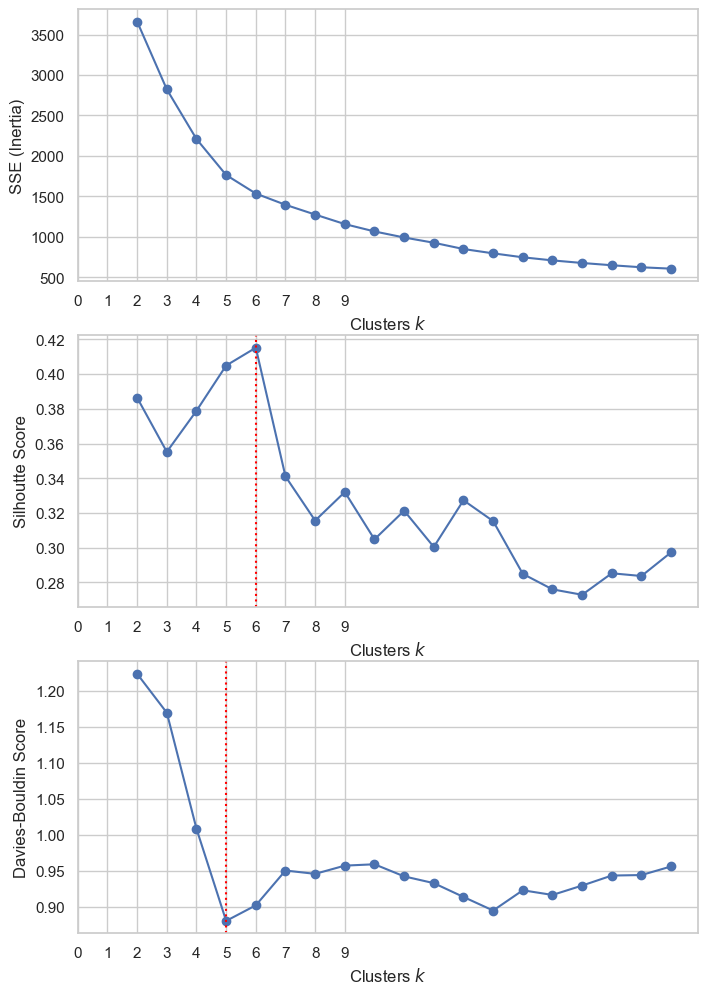

In [63]:
ks = np.arange(2, 21)
metrics_vs_k = np.zeros((len(ks), 4))

# Subsample once
X_sample = resample(X, n_samples=5000, random_state=42)

for i, k in enumerate(ks):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        random_state=42
    ).fit(X)

    labels_sample = kmeans.predict(X_sample)

    metrics_vs_k[i] = [
        k,
        kmeans.inertia_,
        silhouette_score(X_sample, labels_sample),
        davies_bouldin_score(X_sample, labels_sample)
    ]

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
ax[0].scatter(x= metrics_vs_k[:, 0], y= metrics_vs_k[:, 1])
ax[0].plot(metrics_vs_k[:, 0], metrics_vs_k[:, 1])
ax[0].set_xlabel('Clusters $k$')
ax[0].set_ylabel('SSE (Inertia)')
ax[0].set_xticks(ticks= np.arange(0, 10, 1))

ax[1].scatter(x= metrics_vs_k[:, 0], y= metrics_vs_k[:, 2])
ax[1].plot(metrics_vs_k[:, 0], metrics_vs_k[:, 2])
ax[1].axvline(x= metrics_vs_k[metrics_vs_k[:, 2].argmax()][0], c= 'red', linestyle= ':')
ax[1].set_ylabel('Silhoutte Score')
ax[1].set_xlabel('Clusters $k$')
ax[1].set_xticks(ticks= np.arange(0, 10, 1))

ax[2].scatter(x= metrics_vs_k[:, 0], y= metrics_vs_k[:, 3])
ax[2].plot(metrics_vs_k[:, 0], metrics_vs_k[:, 3])
ax[2].axvline(x= metrics_vs_k[metrics_vs_k[:, 3].argmin()][0], c= 'red', linestyle= ':')
ax[2].set_ylabel('Davies-Bouldin Score')
ax[2].set_xlabel('Clusters $k$')
ax[2].set_xticks(ticks= np.arange(0, 10, 1))

plt.show()

In [64]:
kmeans = KMeans(
    n_clusters=int(metrics_vs_k[metrics_vs_k[:, 3].argmin()][0]),
    init="k-means++",
    random_state=42
).fit(X)

centers = kmeans.cluster_centers_
labels = kmeans.labels_


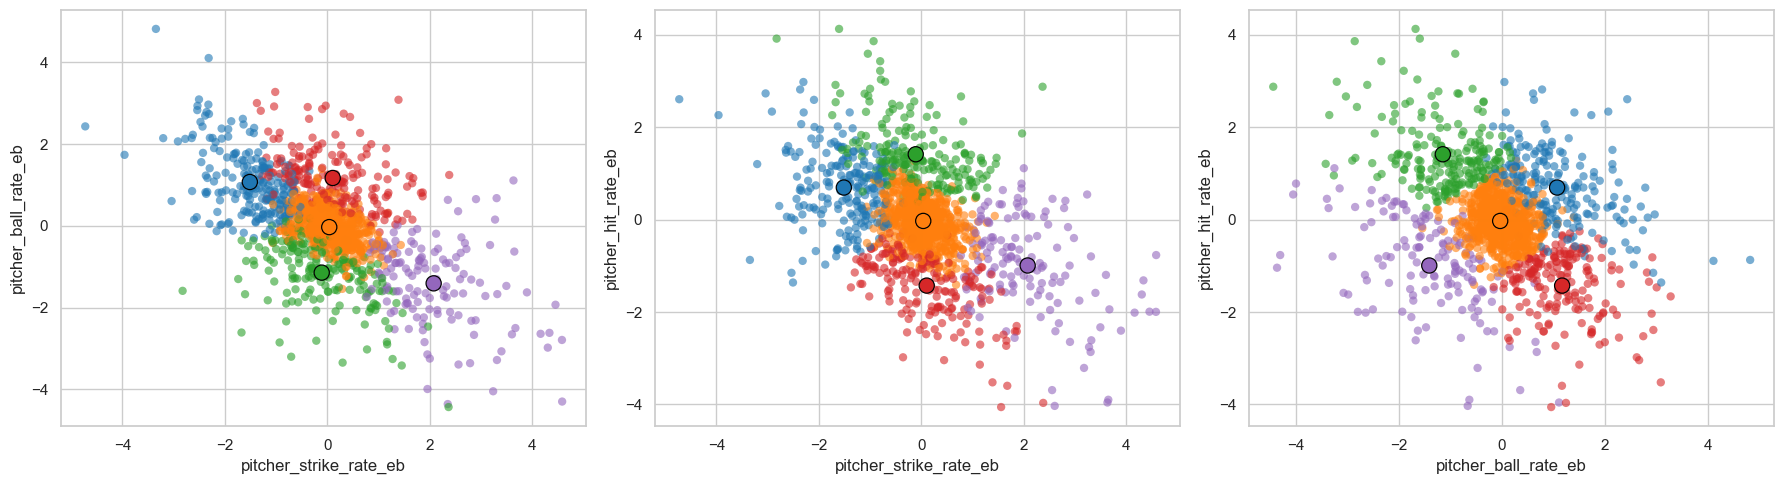

In [ ]:
pairs = list(itertools.combinations(range(3), 2))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (i, j) in zip(axes, pairs):
    sns.scatterplot(
        x=X.iloc[:, i],
        y=X.iloc[:, j],
        hue=labels,
        palette="tab10",
        alpha=0.6,
        edgecolor="none",
        legend=False,
        ax=ax
    )

    sns.scatterplot(
        x=centers[:, i],
        y=centers[:, j],
        hue=np.arange(len(centers)),
        palette="tab10",
        s=120,
        edgecolor="black",
        legend=False,
        ax=ax
    )

    ax.set_xlabel(df_kmeans.columns[i])
    ax.set_ylabel(df_kmeans.columns[j])

plt.tight_layout()
plt.show()


# Create Kmeans Transformer Class
Below we create our own kmeans transformer that will use Davies-Bouldin score to estimate the optimal cluster number for kmeans in the fit() method. With the optimal cluster number, the fit() method will then fit to the training data set (if fit() is called on the training data as it should be) and it will calculate the centers of each of the clusters as well as the distances of each player in the training data to the center. After this, the transform() method will map each player in the dataframe to their corresponding distances (if already calculated in the fit method), or it will impute them based on the cluster centers fit to the training data. For example, if a player in the test data frame is not in the training data frame, the player's distances to each cluster in the test data frame will be calculated. If the player is in both training and test, the players distances to cluster centers will be mapped to save time.

In [76]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

class PlayerKmeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, player_col, cluster_cols=None, max_k=10, prefix='dist'):
        self.player_col = player_col
        self.cluster_cols = cluster_cols
        self.max_k = max_k
        self.prefix = prefix # Add this
        self.scaler = StandardScaler()
        self.kmeans_ = None
        self.best_k_ = None
        self.pitcher_distances_df_ = None

    def fit(self, X, y=None):
        X_unique = X.groupby(self.player_col)[self.cluster_cols].first().dropna()
        X_scaled = self.scaler.fit_transform(X_unique)
        
        ks = np.arange(2, self.max_k + 1)
        db_scores = []
        for k in ks:
            km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
            db_scores.append(davies_bouldin_score(X_scaled, km.labels_))
        
        self.best_k_ = ks[np.argmin(db_scores)]
        self.kmeans_ = KMeans(n_clusters=self.best_k_, n_init=10, random_state=42)
        self.kmeans_.fit(X_scaled)
        
        distances = self.kmeans_.transform(X_scaled)
        
        # Use the prefix here to make column names unique
        dist_cols = [f'{self.prefix}_center_{i}' for i in range(self.best_k_)]
        self.pitcher_distances_df_ = pd.DataFrame(
            distances, 
            index=X_unique.index, 
            columns=dist_cols
        )
        
        return self

    # transform method remains the same, it will now use the unique dist_cols automatically

    def transform(self, X):
        X_out = X.copy()
        
        # 1. Join the pre-calculated distances based on the pitcher ID
        X_out = X_out.merge(
            self.pitcher_distances_df_, 
            left_on=self.player_col, 
            right_index=True, 
            how='left'
        )
        
        # 2. Handle missing pitchers (new players in test set)
        # If a pitcher wasn't in train, we manually scale their data and use kmeans.transform
        missing_mask = X_out[self.pitcher_distances_df_.columns[0]].isna()
        if missing_mask.any():
            missing_pitchers = X_out.loc[missing_mask, [self.player_col] + self.cluster_cols].drop_duplicates()
            
            # Scale and transform
            missing_scaled = self.scaler.transform(missing_pitchers[self.cluster_cols])
            missing_dists = self.kmeans_.transform(missing_scaled)
            
            # Map them back
            dist_cols = self.pitcher_distances_df_.columns
            for i, col in enumerate(dist_cols):
                # Create a map for the missing guys
                missing_map = dict(zip(missing_pitchers[self.player_col], missing_dists[:, i]))
                X_out.loc[missing_mask, col] = X_out.loc[missing_mask, self.player_col].map(missing_map)
        
        return X_out

In [77]:
kmeans_pipeline = Pipeline([
    ('pitcher_archetype', PlayerKmeansTransformer(
        player_col='pitcher',
        cluster_cols=['pitcher_strike_rate_eb', 'pitcher_ball_rate_eb', 'pitcher_hit_rate_eb'],
        prefix='pitcher'
    )),
    ('batter_archetype', PlayerKmeansTransformer(
        player_col='batter',
        cluster_cols=['batter_strike_rate_eb', 'batter_ball_rate_eb', 'batter_hit_rate_eb'],
        prefix='batter'
    ))
])

In [78]:
X_train = kmeans_pipeline.fit_transform(X_train)
X_test=kmeans_pipeline.transform(X_test)
X_val = kmeans_pipeline.transform(X_val) 

# Apply Feature Engineering, One-Hot Encoding, and Final Preprocessing

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

pitcher_kmeans_cluster_features = [
    'pitcher_strike_rate_eb', 
    'pitcher_ball_rate_eb', 
    'pitcher_hit_rate_eb'
]

# The inputs for Batter Archetypes
# These answer: "How disciplined or aggressive is this batter?"
batter_kmeans_cluster_features = [
    'batter_strike_rate_eb', 
    'batter_ball_rate_eb', 
    'batter_hit_rate_eb'
]

categorical_features=[
    'game_type',
    'stand',
    'p_throws',
    'if_fielding_alignment',
    'of_fielding_alignment'
]

# 1. Feature Creator (The "Count" String)
def make_count_feature(X):
    X = X.copy()
    X['count'] = X['balls'].astype(str) + "-" + X['strikes'].astype(str)
    return X

count_gen = FunctionTransformer(make_count_feature)

# 2. Categorical Mini-Pipeline
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. The Final Processor
# We wait until the VERY end to OHE everything. This keeps the intermediate
# dataframes clean and readable.
processor = ColumnTransformer([
    # Encode the standard categories
    ("cat_encoding", cat_pipeline, categorical_features),
    
    # Encode the count string we created in step 1
    ("count_ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['count']),
    
    # Passthrough the EB rates and K-Means distances
    # Note: Use a regex or list comprehension if the number of k-means cols is dynamic
    ("rates_and_dist", "passthrough", 
     pitcher_kmeans_cluster_features + 
     batter_kmeans_cluster_features +
     [c for c in X_train.columns if 'center' in c]) # This catches your pitcher_center_X and batter_center_X
], remainder="passthrough")

processor.set_output(transform="pandas")

# 4. The Master Assembly
full_pipeline = Pipeline([
    ("eb_logic", eb_pipeline),        # Adds EB rates
    ("count_step", count_gen),        # Adds 'count' string
    ("kmeans_logic", kmeans_pipeline),# Adds distances (from your updated class)
    ("final_prep", processor)         # One-Hot Encodes and organizes everything
])

In [96]:
# Fit and Transform
X_train_final = full_pipeline.fit_transform(train_df)
X_test_final = full_pipeline.transform(test_df)
X_val_final = full_pipeline.transform(val_df)

# # clean column names
X_train_final.columns = [
    c.replace("remainder__", "") 
    for c in X_train_final.columns
]
X_test_final.columns = [
    c.replace("remainder__", "") 
    for c in X_test_final.columns
]
X_val_final.columns = [
    c.replace("remainder__", "") 
    for c in X_val_final.columns
]

# create target variable df for train,test,val
mapping = {'strike': 0, 'ball': 1, 'hit': 2, 'non-strike foul': 3}
y_train_final = X_train_final['outcome_coarse'].map(mapping)
y_test_final = X_test_final['outcome_coarse'].map(mapping)
y_val_final = X_val_final['outcome_coarse'].map(mapping)

In [ ]:
# create a list of features that we want to keep for training
training_features = ['game_year', 'outs_when_up', 'inning', 'at_bat_number', 'bat_score', 'fld_score']

for col_name in X_train_final.columns:
    if 'count_ohe__' in col_name:
        training_features.append(col_name)
    elif 'rates_and_dist__' in col_name:
        training_features.append(col_name)
    elif 'cat_encoding__' in col_name:
        training_features.append(col_name)

# get rid of columns that are not for training
X_train_final = X_train_final[training_features]
X_test_final = X_test_final[training_features]
X_val_final = X_val_final[training_features]


# Modeling: Random Forest

There are numerous hyperparameters that can be used and tuned for a Random Forest classifier, and to try and optimize their values, we decided to use randomized search cross validation over a parameter distribution defining different possible values of the hyperparameters: ‘max_depth’- maximum depth of a tree in the forest, ‘max_features’ - maximum number of features a tree can have, as a proportion of the training data set, and ‘n_estimators’- number of trees in the random forest.


In sports analytics a standard K-fold cross-validation can lead to ‘temporal leakage’, given that games occur in sequence of one another. To maintain the integrity of the model, a Predefined Split strategy was implemented where we partitioned the data set into a training and fixed validation set based on chronological order (ie. training set was earlier at bats in the data set and validation was later at bats in the data set). This approach ensures that the hyperparameters are tuned based on the model’s ability to predict unseen future data.


Rather than optimizing for accuracy, the model was trained using Negative Log Loss as the primary scoring metric. This was important because we have multiple target variable values that are possible, and on top of that we want a model that is not penalizing itself on its ability to predict the outcome of the target variable, but rather to predict the probabilities of the possible target variable outcome. Neg Log Loss penalizes confident but wrong predictions more than uncertain ones forcing the random forest in the direction of producing calibrated probabilities of outcomes. Additionally, to prevent the model from ignoring low frequency outcomes such as hit, or non-strike fouls, we set the class_weight parameter to ‘balanced’ in the RandomForestClassifier(). This inversely weights the outcome classes based on their frequency, forcing the model algorithm to learn distinct signatures on rarer outcomes.


In [100]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
import numpy as np

# 1. Combine your training and validation sets
# (X_train/y_train are your training data, X_val/y_val are your fixed validation data)
X_combined = pd.concat([X_train_final, X_val_final])
y_combined = pd.concat([y_train_final, y_val_final])

# 2. Create a list of indices:
# -1 for rows that should be used for training
#  0 for rows that should be used for validation
split_index = [-1] * len(X_train_final) + [0] * len(X_val_final)

# 3. Initialize PredefinedSplit
pds = PredefinedSplit(test_fold=split_index)

param_dist = {
    'max_depth': [5, 10, 15],
    'max_features':['sqrt', 0.3, 0.5],
    'n_estimators': [50, 100]
}
# 4. Update your RandomizedSearchCV
random_forest_randomized_search_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=20,
    cv=pds,             # <--- Use the PredefinedSplit here
    scoring='neg_log_loss', # Or your preferred metric
    random_state=42,
    n_jobs=-1,
    verbose=4
)

# 5. Fit using the combined data
random_forest_randomized_search_cv.fit(X_combined, np.ravel(y_combined))

Fitting 1 folds for each of 18 candidates, totalling 18 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/1] END max_depth=5, max_features=sqrt, n_estimators=50;, score=-1.274 total time=  49.2s
[CV 1/1] END max_depth=10, max_features=sqrt, n_estimators=50;, score=-1.224 total time= 1.5min
[CV 1/1] END max_depth=5, max_features=0.3, n_estimators=50;, score=-1.243 total time= 1.5min
[CV 1/1] END max_depth=5, max_features=sqrt, n_estimators=100;, score=-1.276 total time= 1.6min
[CV 1/1] END max_depth=5, max_features=0.5, n_estimators=50;, score=-1.228 total time= 2.4min
[CV 1/1] END max_depth=10, max_features=0.3, n_estimators=50;, score=-1.207 total time= 2.8min
[CV 1/1] END max_depth=5, max_features=0.3, n_estimators=100;, score=-1.246 total time= 2.9min
[CV 1/1] END max_depth=10, max_features=sqrt, n_estimators=100;, score=-1.223 total time= 2.9min
[CV 1/1] END max_depth=15, max_features=sqrt, n_estimators=50;, score=-1.199 total time= 2.1min
[CV 1/1] END max_depth=5, max_features=0.5, n_estimators=100;, score=-1.226 total time= 4.6min
[CV 1/1] END max_depth=10, max_features=0.5, n_

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0], shape=(1238321,))),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': ['sqrt', 0.3, 0.5],
                                        'n_estimators': [50, 100]},
                   random_state=42, scoring='neg_log_loss', verbose=4)

### Save Best Random Forest Model

In [101]:
import joblib

best_model = random_forest_randomized_search_cv.best_estimator_

joblib.dump(best_model, "rf_best_model.pkl")


['rf_best_model.pkl']

### Show Results of Cross Validation on Random Forest Classifier

In [106]:
results_df = pd.DataFrame(random_forest_randomized_search_cv.cv_results_)

# Sort by performance to see the top performers
results_df = results_df.sort_values(by='rank_test_score')

# Display the most important columns
results_df.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
17,598.182936,0.0,3.347424,0.0,100,0.5,15,"{'n_estimators': 100, 'max_features': 0.5, 'ma...",-1.188633,-1.188633,0.0,1
15,372.786569,0.0,3.311202,0.0,100,0.3,15,"{'n_estimators': 100, 'max_features': 0.3, 'ma...",-1.189244,-1.189244,0.0,2
16,316.229459,0.0,1.604789,0.0,50,0.5,15,"{'n_estimators': 50, 'max_features': 0.5, 'max...",-1.189471,-1.189471,0.0,3
14,212.639086,0.0,1.929242,0.0,50,0.3,15,"{'n_estimators': 50, 'max_features': 0.3, 'max...",-1.190636,-1.190636,0.0,4
12,125.295519,0.0,2.889874,0.0,50,sqrt,15,"{'n_estimators': 50, 'max_features': 'sqrt', '...",-1.198835,-1.198835,0.0,5
13,232.341588,0.0,3.312011,0.0,100,sqrt,15,"{'n_estimators': 100, 'max_features': 'sqrt', ...",-1.199140,-1.199140,0.0,6
11,440.170094,0.0,1.830710,0.0,100,0.5,10,"{'n_estimators': 100, 'max_features': 0.5, 'ma...",-1.203042,-1.203042,0.0,7
10,259.705634,0.0,1.504759,0.0,50,0.5,10,"{'n_estimators': 50, 'max_features': 0.5, 'max...",-1.203545,-1.203545,0.0,8
9,319.393955,0.0,1.944008,0.0,100,0.3,10,"{'n_estimators': 100, 'max_features': 0.3, 'ma...",-1.206252,-1.206252,0.0,9
8,166.757259,0.0,1.559293,0.0,50,0.3,10,"{'n_estimators': 50, 'max_features': 0.3, 'max...",-1.206880,-1.206880,0.0,10


### Model Evaluation
Below we compare the Random Forest best_model to a baseline model that uses the league average proportions as the probabilities of outcomes for every pitch in the log loss scoring.

We calculated that a Naive baseline model that predicted probability of pitch outcomes simply based on probability of an outcome in the data set would give a Log Loss of 1.22. This means that if strikes made up 45% of the test set, then in the Log Loss equation of a Naive model, we would give the probability of a strike 45% across all pitches. A Naive model is somewhat strong based on the principle that strikes and balls outweigh other outcomes greatly, and simply predicting these outcomes at their probabilistic rate based on frequency in the data set is decent. All that to say, any improvement from that baseline is significant, especially one that jumps from 1.22 to 1.18.

In [134]:
from sklearn.metrics import log_loss
import numpy as np

# 1. Calculate the global frequencies of your 4 classes in the training set
# This represents the "League Average" knowledge
proportions = y_train_final.value_counts(normalize=True).sort_index()
print("League Average Proportions:\n", proportions)

# 2. Create a 'naive' prediction matrix for the test set
# Every single pitch in X_test gets assigned the exact same global probability
n_test_samples = len(y_test_final)
naive_probs = np.tile(proportions.values, (n_test_samples, 1))

# 3. Calculate the Log Loss
baseline_log_loss = log_loss(y_test_final, naive_probs)

print(f"Naive Baseline Log Loss: {baseline_log_loss:.4f}")
print(f"Your Model Log Loss: 1.1886")
print(f"Improvement: {baseline_log_loss - 1.1886:.4f}")

League Average Proportions:
 outcome_coarse
0    0.396150
1    0.356902
2    0.178308
3    0.068640
Name: proportion, dtype: float64
Naive Baseline Log Loss: 1.2256
Your Model Log Loss: 1.1886
Improvement: 0.0370


### Most Important Features

Below we take a look at the most important features for the random forest best_model. 

Note that the top 4 features are all "two-strike" counts (1-2, 3-2, 2-2, 0-2). This makes sense theoretically, as these counts have the highest influence on the probability of a terminal outcome (Strike or Hit). The fact that EB-adjusted rates appear higher than Archetype distances suggests that what a player does (their ability to limit hits or take balls) is a more immediate predictor of the next pitch outcome than their style (archetype), though both provide signal. The top 5 features alone account for nearly 53% of the model's decision-making power. This shows that the Random Forest has a very clear understanding of the "Critical Path" of a plate appearance.

The overwhelming dominance of "two-strike" counts (1-2, 3-2, 2-2, 0-2) in the Top 5 underscores the Situational Gravity. At these high-leverage junctures in an at bat, the physical possibilities of the game contract; the pitcher is forced to maximize "strike-seeking" behavior while the batter must expand their zone. The model correctly identifies that the "state" of the at-bat is the primary engine of outcome probability, establishing the baseline upon which all other features act.

Once the model accounts for the count and the player’s general talent level, it uses the Pitcher Centers to understand how that talent is delivered. For example, a strike rate of 65% looks very different coming from a "Power Pitcher" (who might get whiffs) versus a "Crafty Specialist" (who might get weak contact).


In [ ]:
importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": X_train_final.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importance_df_new = feature_importance_df.head(20)


/var/folders/lb/23387f852w12tqnqvkyjrvrw0000gn/T/ipykernel_80257/1708937510.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance_df_new['category'] = feature_importance_df_new['feature'].apply(categorize_feature)
/var/folders/lb/23387f852w12tqnqvkyjrvrw0000gn/T/ipykernel_80257/1708937510.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


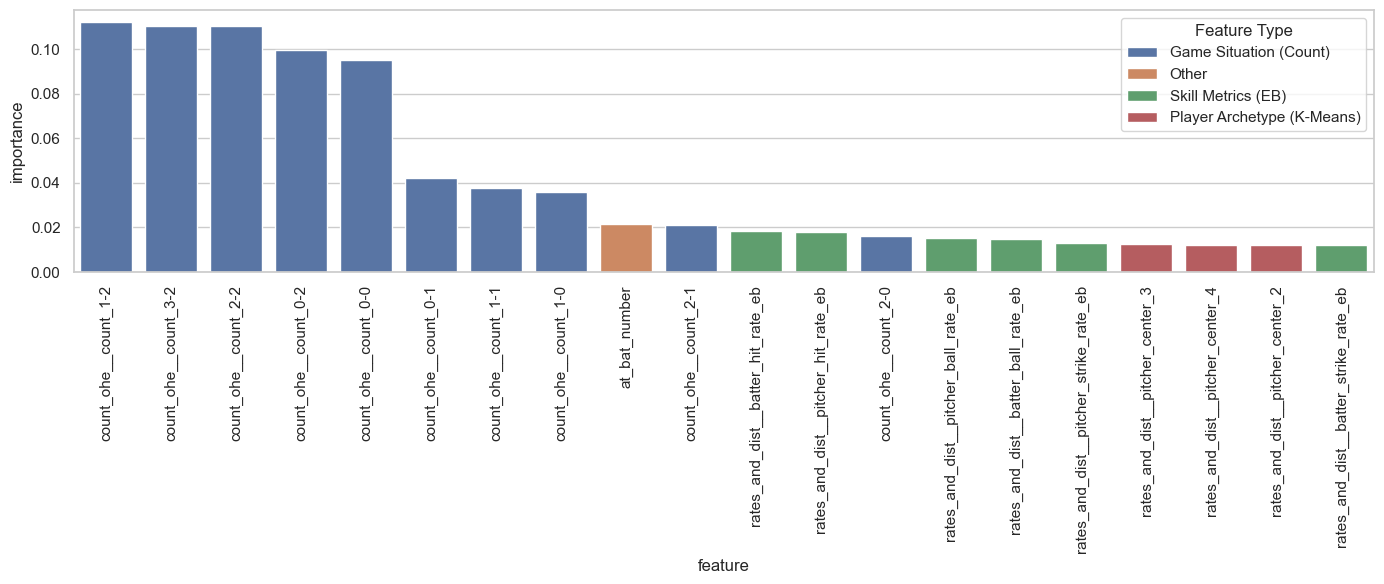

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a helper function or logic to categorize the features
def categorize_feature(name):
    name = name.lower()
    if 'count' in name:
        return 'Game Situation (Count)'
    elif 'eb' in name:
        return 'Skill Metrics (EB)'
    elif 'center' in name:
        return 'Player Archetype (K-Means)'
    else:
        return 'Other'

# 2. Apply the categorization to your DataFrame
feature_importance_df_new['category'] = feature_importance_df_new['feature'].apply(categorize_feature)

# 3. Plot using the 'hue' parameter
fig, ax = plt.subplots(figsize=(14, 6))

# Note: dodge=False ensures the bars stay centered on the x-axis ticks
sns.barplot(
    ax=ax, 
    data=feature_importance_df_new, 
    x='feature', 
    y='importance', 
    hue='category',
    dodge=False 
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(title='Feature Type')
plt.tight_layout()
plt.show()

### Visualize Tree from Random Forest

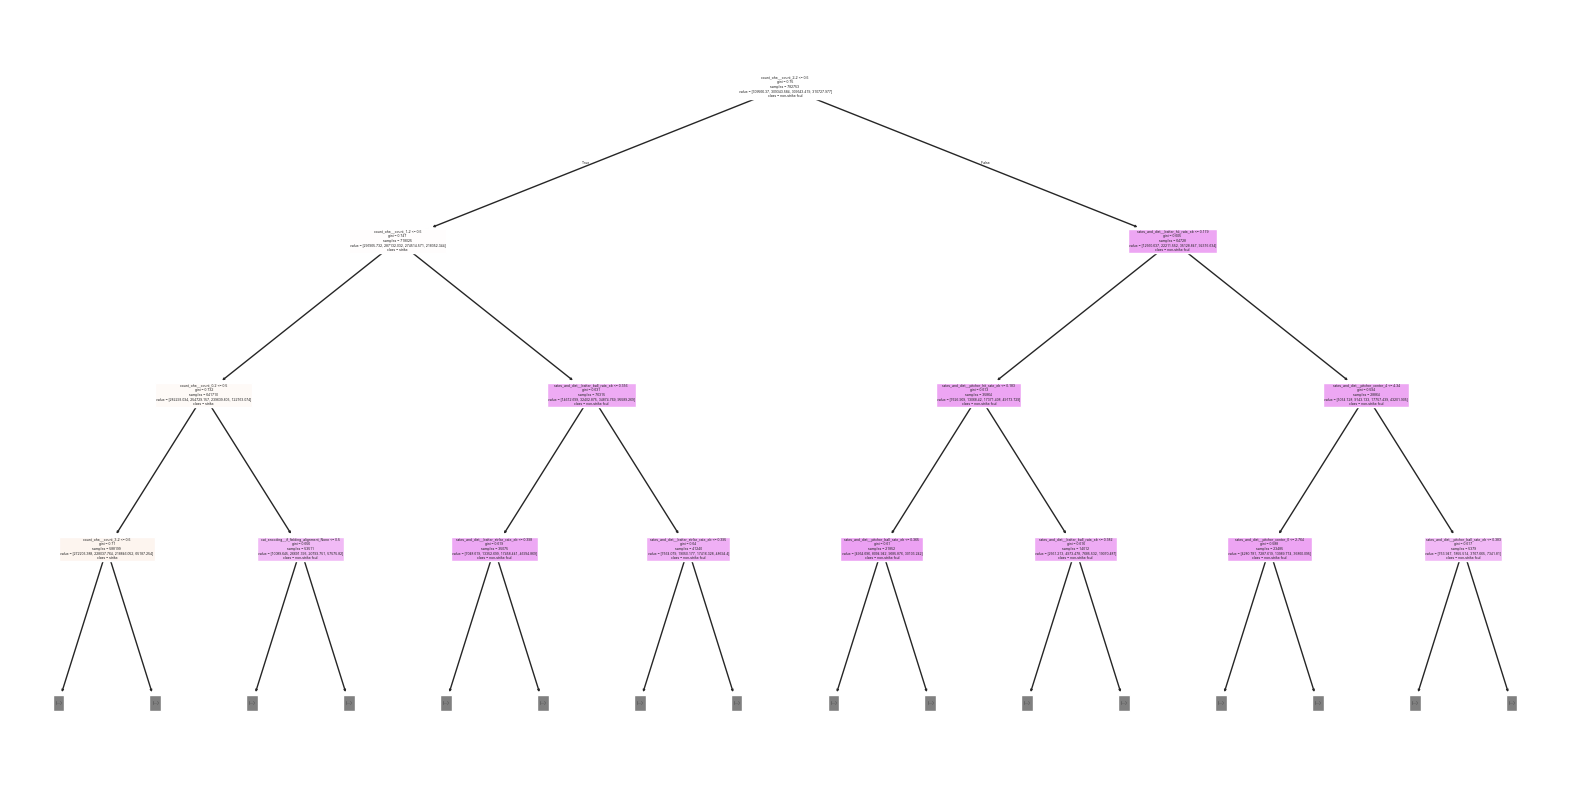

In [ ]:
# Assuming your model is named 'rf_model'
plt.figure(figsize=(20,10))
plot_tree(best_model.estimators_[0], 
          feature_names=training_features, 
          class_names=['strike','ball','hit','non-strike foul'], 
          filled=True, 
          max_depth=3) # Limit depth so it's readable
plt.show()